# TensorFlow Implementation of Cox Proportional Hazards

In [61]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%load_ext autotime
%matplotlib inline

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 7.85 ms


In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

from lifelines.utils import concordance_index
import copy

time: 1.73 s


In [3]:
print(tf.__version__)

2.0.0
time: 762 µs


# Dataset Transformation

Using Rossi recidivism dataset from Lifelines
Using Lifelines to process the data

# Dataset
note: censored = lost-to-followup

* X are the covariates
* T are the event times in weeks (when arrest or censored)
* E are the events TRUE = Arrest, False = censored
* W are optional weights


In [26]:
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd
from lifelines.datasets import load_rossi
from IPython.core.debugger import set_trace

df = load_rossi()

#df['age_strata'] = pd.cut(df['age'], np.arange(0, 80, 5))
#df = df.drop('age', axis=1)

time: 23.6 ms


In [27]:
# Use lifelines to preprocess the data
cph = CoxPHFitter()
cph.duration_col = 'week'
cph.event_col = 'arrest'
cph.weights_col = None
cph._n_examples = df.shape[0]
cph.cluster_col = None
# No strata
#cph.strata=['age_strata', 'wexp']
cph.strata = None
#Preprocess the data
X, T, E, W, original_index, _clusters = cph._preprocess_dataframe(df = df)

time: 22.3 ms


In [28]:
X.head()

,fin,age,race,wexp,mar,paro,prio
313,0.0,20.0,1.0,0.0,0.0,0.0,0.0
100,0.0,44.0,1.0,1.0,0.0,1.0,2.0
183,0.0,30.0,1.0,0.0,0.0,1.0,3.0
416,0.0,18.0,1.0,1.0,0.0,0.0,1.0
79,0.0,19.0,1.0,0.0,0.0,0.0,3.0


time: 10.7 ms


In [29]:
T

313     1.0
100     2.0
183     3.0
416     4.0
79      5.0
       ... 
157    52.0
156    52.0
155    52.0
164    52.0
431    52.0
Name: week, Length: 432, dtype: float64

time: 15.4 ms


In [30]:
E

313     True
100     True
183     True
416     True
79      True
       ...  
157    False
156    False
155     True
164    False
431    False
Name: arrest, Length: 432, dtype: bool

time: 4.64 ms


# Custom Loss Function. negative partial likelihood

https://github.com/sebp/scikit-survival/blob/master/sksurv/linear_model/coxph.py#L127  
https://en.wikipedia.org/wiki/Proportional_hazards_model#Tied_times
<img src = https://wikimedia.org/api/rest_v1/media/math/render/svg/3579bc338b85b36ac17b499e7b69cf1210c67b0f>

In [34]:
# Parial Likelihood - Only computed at fail times!
# The loss is the negative likelihood
# Cox model says failrate, lambda = labda0*exp(BX), where lambda0 is base hazard. The exponentiated part is "risk"
# B are coefficients of the covars, X
# The partial likelihood is found by dividing the risk of the subject that failed 
# by the risk of all subjects that could have failed at time t. Assumption is that only one failure at a time.
# Likelihood would be maximized if the subject that failed was at most risk, while all others at minimal risk.
# Current implementation below does not handle ties yet.

class PL(tf.keras.losses.Loss):
    def __init__(self, T, E, W):
        super().__init__()
        # Need failure times for ties, E are events, and W (don't care yet)
        self.T = T
        self.E = E
        self.W = W

    def loss(self, y_true, y_pred):   
        # y_true and y_pred must be time ordered! This means 'X' must be time ordered before fitting
        data = tf.stack([tf.squeeze(y_pred), T, E], 1)
        # j is event index
        S = 0
        j = 0
        for i in E:
            # find failures. Compute risk of that subject, sum risk of all subjects that outlived this subject
            # Since we ordered by time, we just sum from j, the index, to the end
            if i:
                S += -tf.math.log(tf.exp(data[j,0])/tf.reduce_sum(tf.exp(data[j:,0])))
            #increment indexer
            j += 1
        #print(S)

        return S


time: 2.46 ms


# Custom Training

In [38]:
def train_step(my_data, train_labels):
    with tf.GradientTape() as tape:
        # Make a prediction and squeeze so tensor dims work with train_labels dims
        y_pred = tf.squeeze(model(my_data))
        # Compute the loss
        loss_value = loss_object(train_labels, y_pred)
        #print(loss_value)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, model.trainable_variables)
    # Update
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    y_pred = tf.squeeze(model(my_data))
    #print(loss_object(train_labels, y_pred))
    #print(loss_value)

time: 1.39 ms


In [44]:
def train(my_data, train_labels, epochs):
    for epoch in range(epochs):
        train_step(my_data, train_labels)
        if epoch % 100 == 0:
            print ('Epoch {} finished'.format(epoch))

time: 930 µs


# Build "Shallow" Cox Model in TF. Equivalent to model in Lifelines

In [83]:
#Initialize model with new input size
optimizer = tf.keras.optimizers.RMSprop(0.001)
inputs = keras.Input(shape=(len(X.keys()),))
#x = layers.Dense(64, activation='relu')(x)
#x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss = PL(T, E, W).loss, metrics=['mae', 'mse'], )

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
time: 1.02 s


In [84]:
my_data = tf.convert_to_tensor(np.array(X), dtype='int32')
my_data

<tf.Tensor: id=65035947, shape=(432, 7), dtype=int32, numpy=
array([[ 0, 20,  1, ...,  0,  0,  0],
       [ 0, 44,  1, ...,  0,  1,  2],
       [ 0, 30,  1, ...,  0,  1,  3],
       ...,
       [ 0, 25,  0, ...,  0,  1,  1],
       [ 1, 28,  1, ...,  1,  1,  3],
       [ 1, 24,  1, ...,  0,  1,  1]], dtype=int32)>

time: 3.66 ms


In [85]:
optimizer = tf.keras.optimizers.Adam()
loss_object = PL(T, E, W).loss
loss_history = []

time: 1.4 ms


# Train

In [89]:
train(my_data, E, epochs = 1500)

Epoch 0 finished
Epoch 100 finished
Epoch 200 finished
Epoch 300 finished
Epoch 400 finished
time: 1min 21s


Text(0, 0.5, 'Loss')

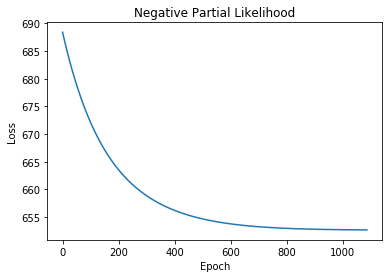

time: 180 ms


In [90]:
plt.plot(loss_history[500::])
plt.title('Negative Partial Likelihood')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Compare Lifelines Cox Model to "Shallow" TF Model
* Should be similar
* Lifelines imlements Efron's method for ties, should be better

In [70]:
# Fit Cox PH to df
cph = CoxPHFitter()
cph.fit(df, duration_col='week', event_col='arrest')

<lifelines.CoxPHFitter:"None", fitted with 432 total observations, 318 right-censored observations>

time: 93.8 ms


# Concordance Metric

In [71]:
# Compare Concordance
predcph = cph.predict_expectation(rossi_dataset)
C1 = concordance_index(rossi_dataset['week'], predcph, event_observed=rossi_dataset['arrest']) 

preddeepcph = np.exp(np.array(tf.squeeze(model(my_data))))
C2 = concordance_index(T, -preddeepcph, event_observed=E) 

time: 69.4 ms


In [72]:
print('Lifelines  C: {0}\nTensorFlow C: {1}'.format(C1, C2))#, C2

Lifelines  C: 0.6403292470997135
TensorFlow C: 0.6412686111502512
time: 2.87 ms


# Coefficient Comparison

In [73]:
cphsum = copy.copy(cph.summary)
cphsum['TFcoef'] = model.get_weights()[0]

time: 12.2 ms


In [74]:
cphsum[['coef', 'TFcoef']]

,coef,TFcoef
fin,-0.379422,-0.390884
age,-0.057438,-0.057884
race,0.313900,0.344179
wexp,-0.149796,-0.161364
mar,-0.433704,-0.444392
paro,-0.084871,-0.097843
prio,0.091497,0.091783


time: 6.39 ms


# These models are very similar

# Train a Deeper Model with same loss function

Add some dense layers and retrain

In [76]:
#Initialize model with new input size
optimizer = tf.keras.optimizers.RMSprop(0.001)
inputs = keras.Input(shape=(len(X.keys()),))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss = PL(T, E, W).loss, metrics=['mae', 'mse'], )

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________
time: 1.01 s


In [78]:
loss_history = []
train(my_data, E, epochs = 4000)

Epoch 0 finished
Epoch 100 finished
Epoch 200 finished
Epoch 300 finished
Epoch 400 finished
Epoch 500 finished
Epoch 600 finished
Epoch 700 finished
Epoch 800 finished
Epoch 900 finished
Epoch 1000 finished
Epoch 1100 finished
Epoch 1200 finished
Epoch 1300 finished
Epoch 1400 finished
Epoch 1500 finished
Epoch 1600 finished
Epoch 1700 finished
Epoch 1800 finished
Epoch 1900 finished
Epoch 2000 finished
Epoch 2100 finished
Epoch 2200 finished
Epoch 2300 finished
Epoch 2400 finished
Epoch 2500 finished
Epoch 2600 finished
Epoch 2700 finished
Epoch 2800 finished
Epoch 2900 finished
Epoch 3000 finished
Epoch 3100 finished
Epoch 3200 finished
Epoch 3300 finished
Epoch 3400 finished
Epoch 3500 finished
Epoch 3600 finished
Epoch 3700 finished
Epoch 3800 finished
Epoch 3900 finished
time: 10min 54s


Text(0, 0.5, 'Loss')

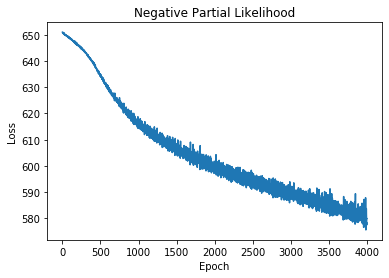

time: 205 ms


In [79]:
plt.plot(loss_history)
plt.title('Negative Partial Likelihood')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Concordance Metric

In [80]:
# Lifelines Concordance
predcph = cph.predict_expectation(rossi_dataset)
C1 = concordance_index(rossi_dataset['week'], predcph, event_observed=rossi_dataset['arrest']) 

preddeepcph = np.exp(np.array(tf.squeeze(model(my_data))))
C2 = concordance_index(T, -preddeepcph, event_observed=E) 

time: 28 ms


In [81]:
print('Lifelines  C: {0}\nTensorFlow C: {1}'.format(C1, C2))#, C2

Lifelines  C: 0.6403292470997135
TensorFlow C: 0.8227537457141515
time: 3.23 ms
